🔍 Found 26 files.
✅ Processed: S5_ClimbOnStool_Synchronized_imputed.csv


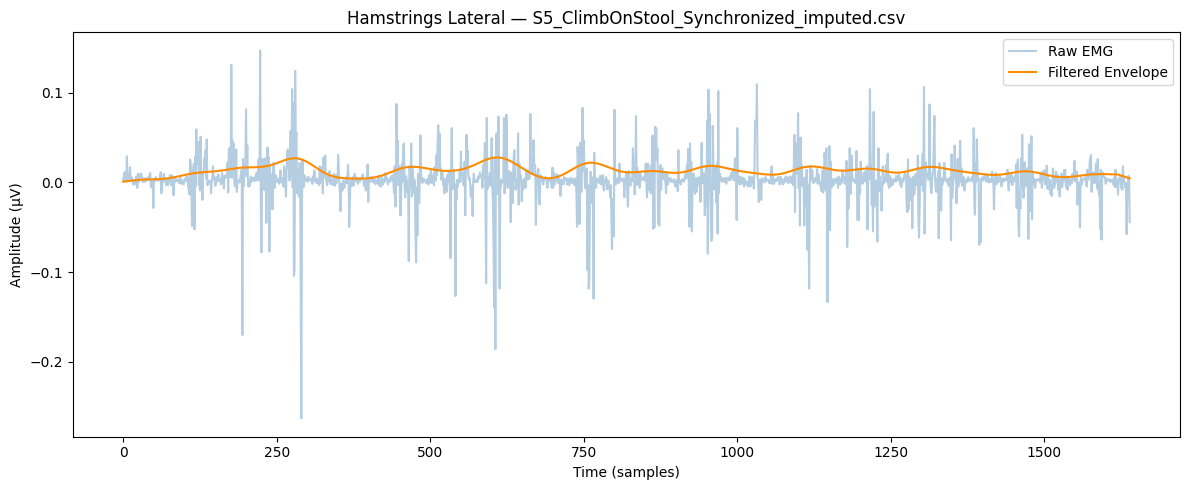

✅ Processed: S5_Dusting_Synchronized_imputed.csv


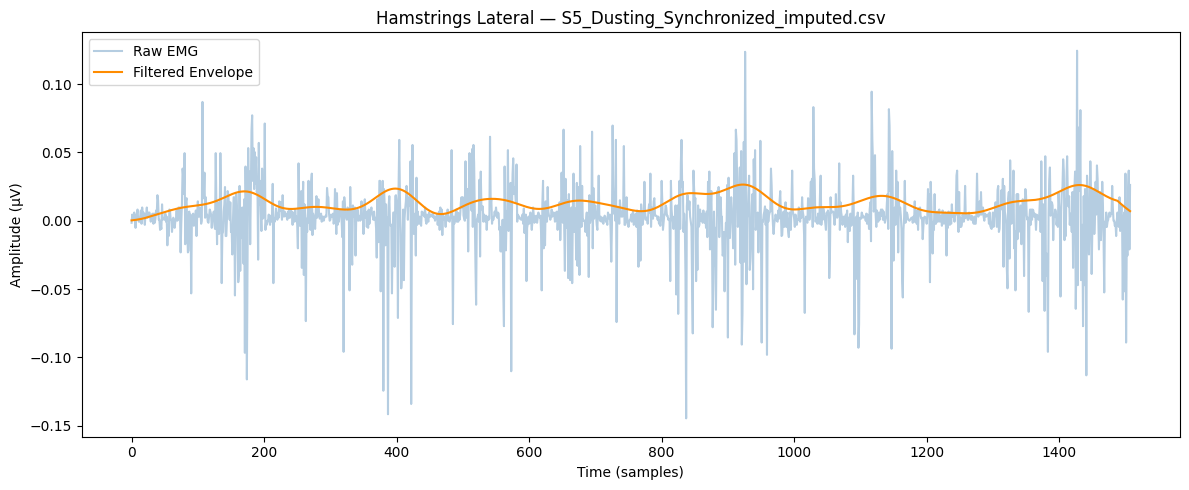

✅ Processed: S5_ForwardLungeLeft_Synchronized_imputed.csv


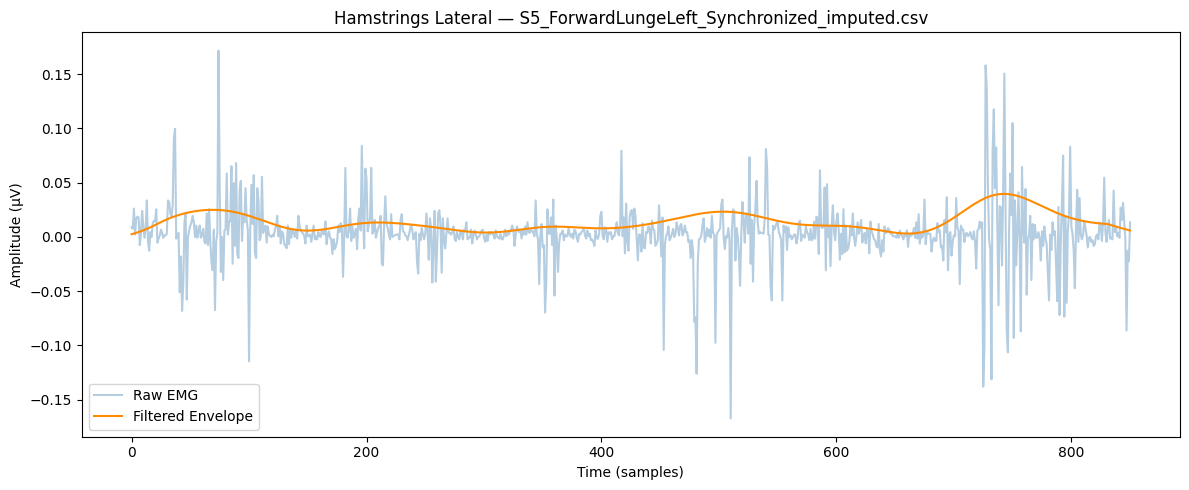

✅ Processed: S5_ForwardLungeRight_Synchronized_imputed.csv


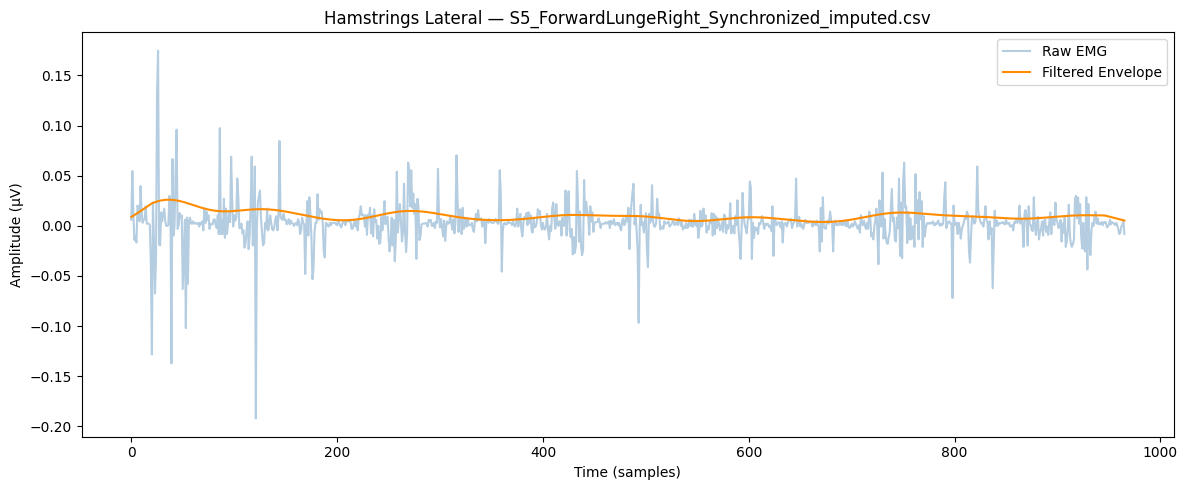

✅ Processed: S5_HandsOnWaist_Synchronized_imputed.csv


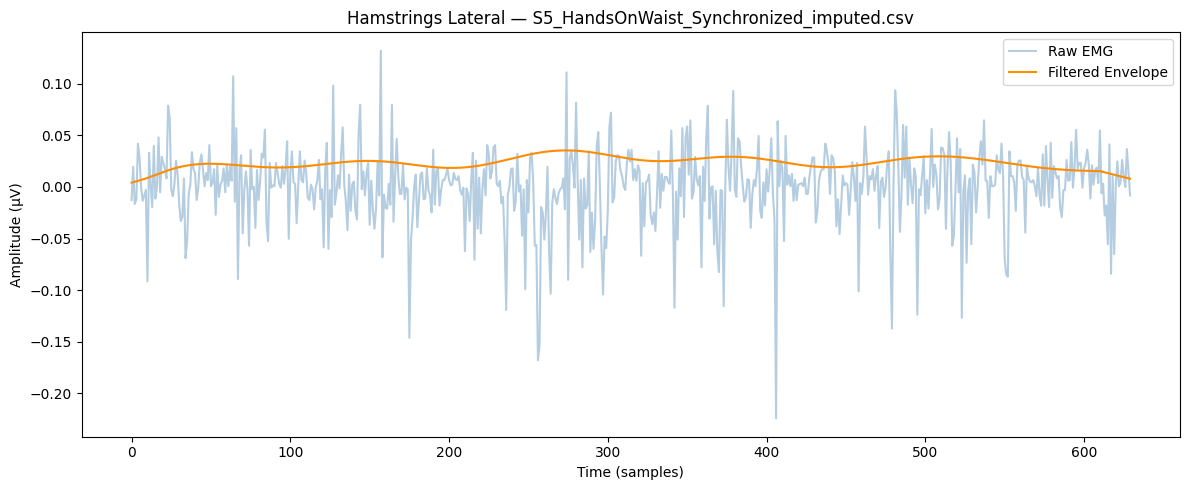

✅ Processed: S5_Malasana_Synchronized_imputed.csv


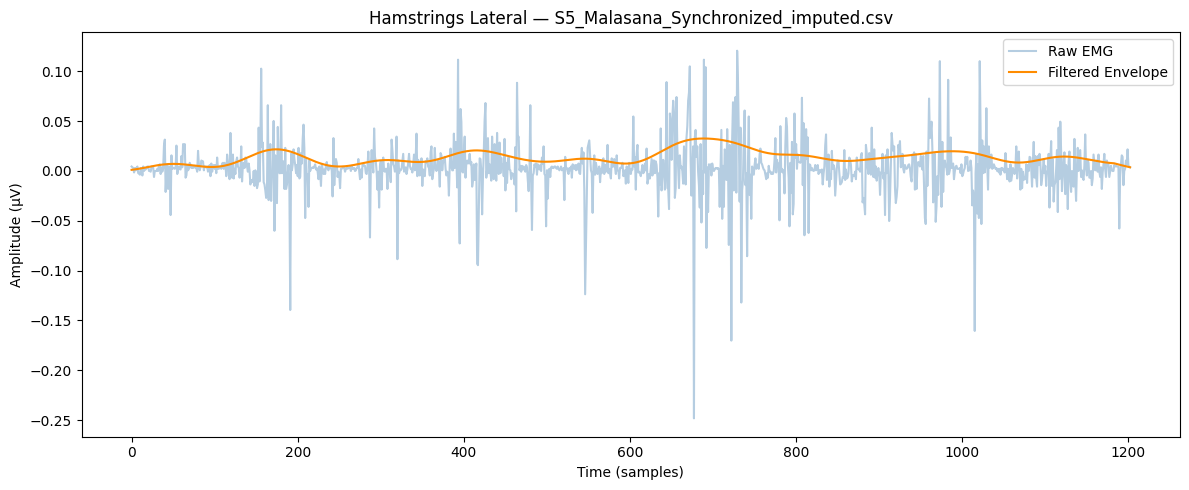

✅ Processed: S5_NeutralStance_Synchronized_imputed.csv


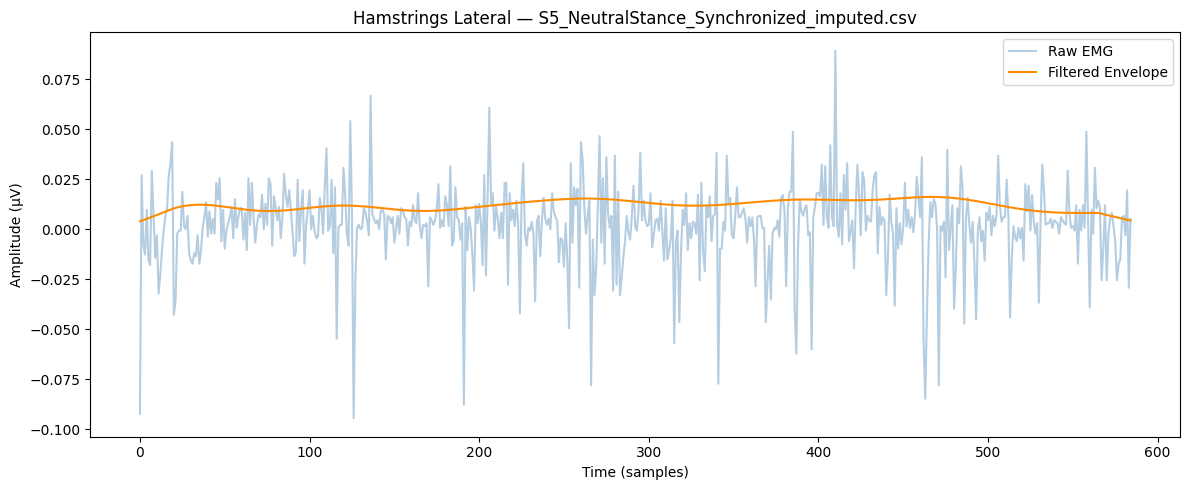

✅ Processed: S5_NormalSquat_Synchronized_imputed.csv


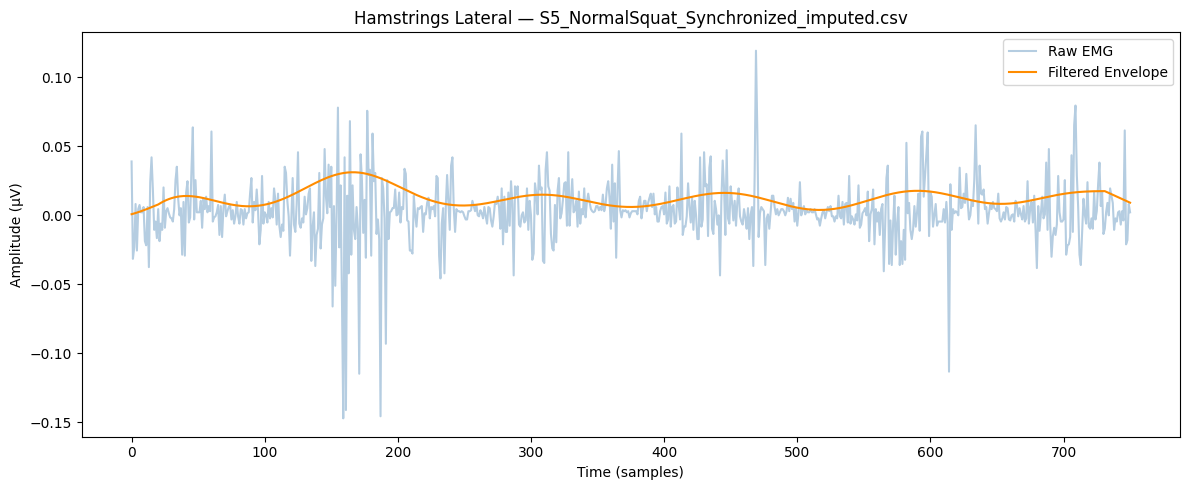

✅ Processed: S5_Parshvakonasana_Synchronized_imputed.csv


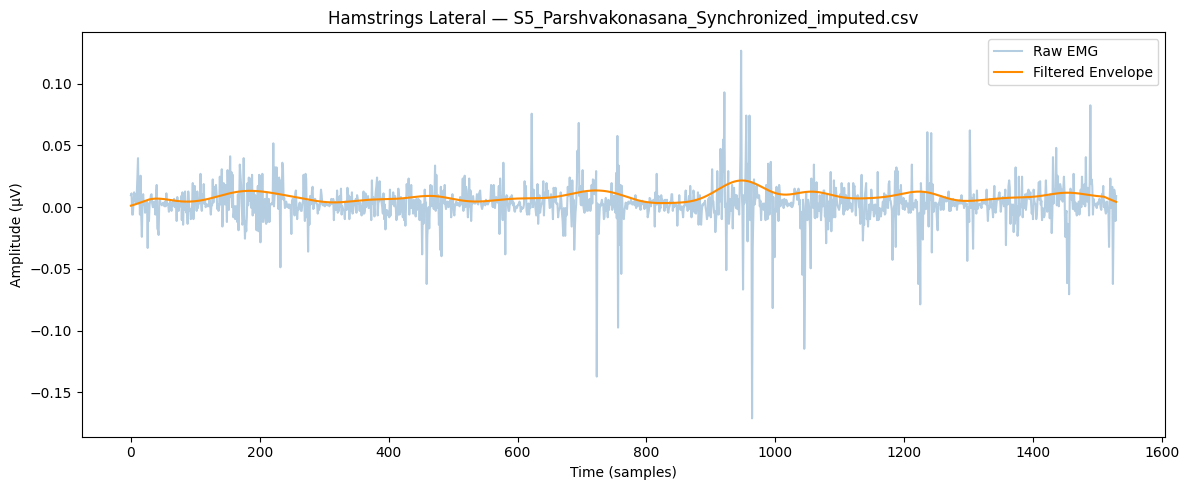

✅ Processed: S5_PickObject_Synchronized_imputed.csv


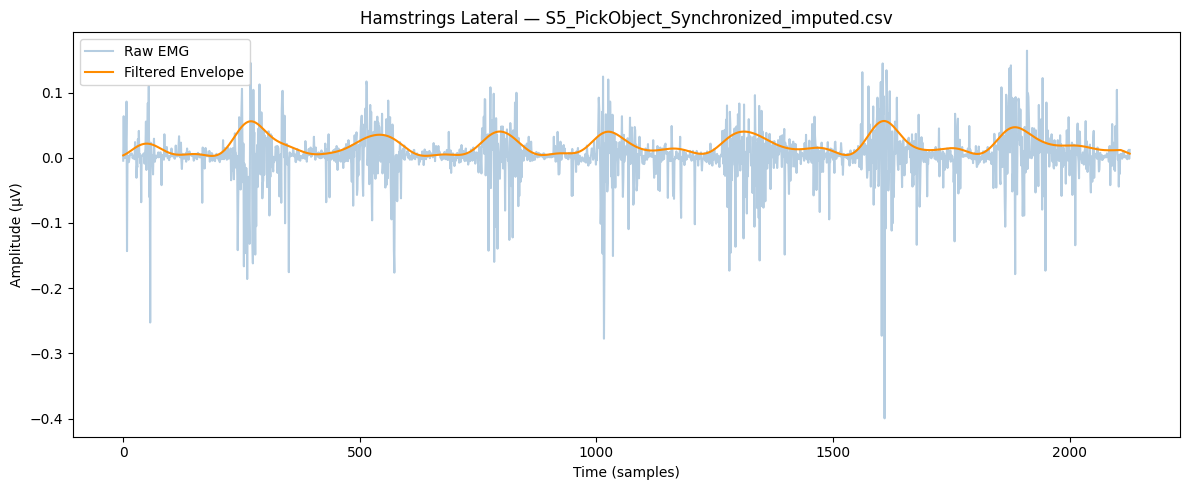

✅ Processed: S5_Point1_Synchronized_imputed.csv


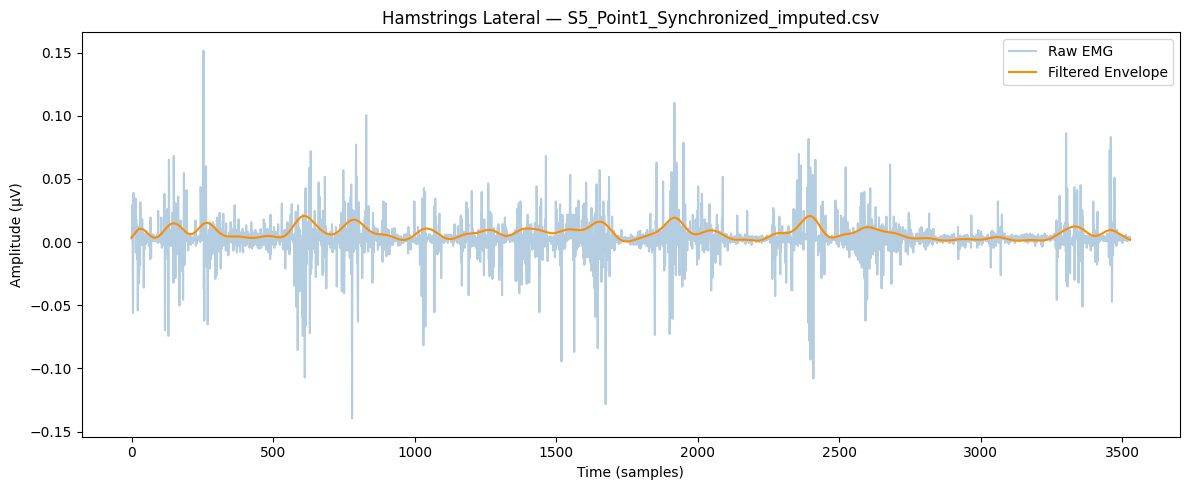

✅ Processed: S5_Point2_Synchronized_imputed.csv


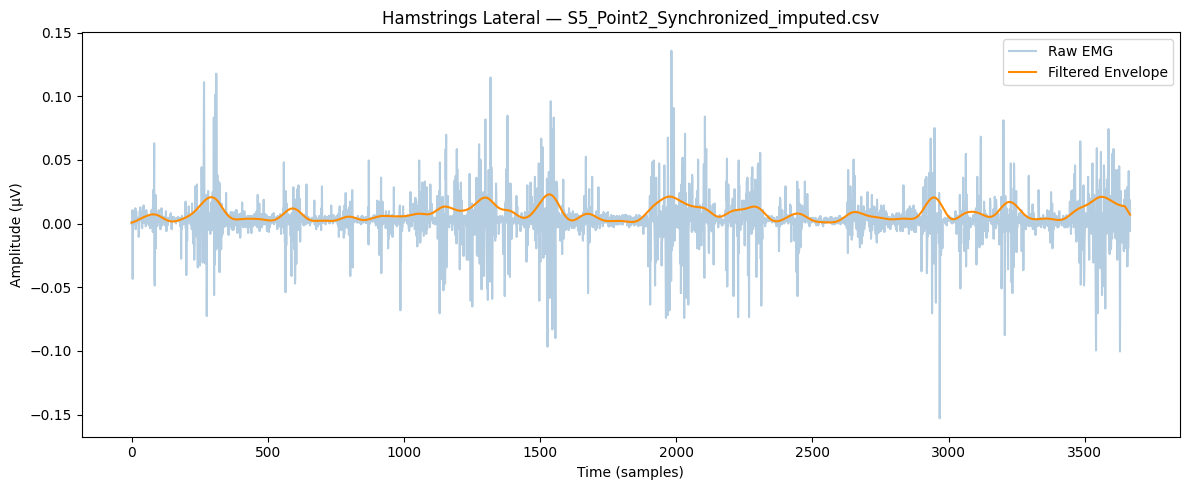

✅ Processed: S5_Point3_Synchronized_imputed.csv


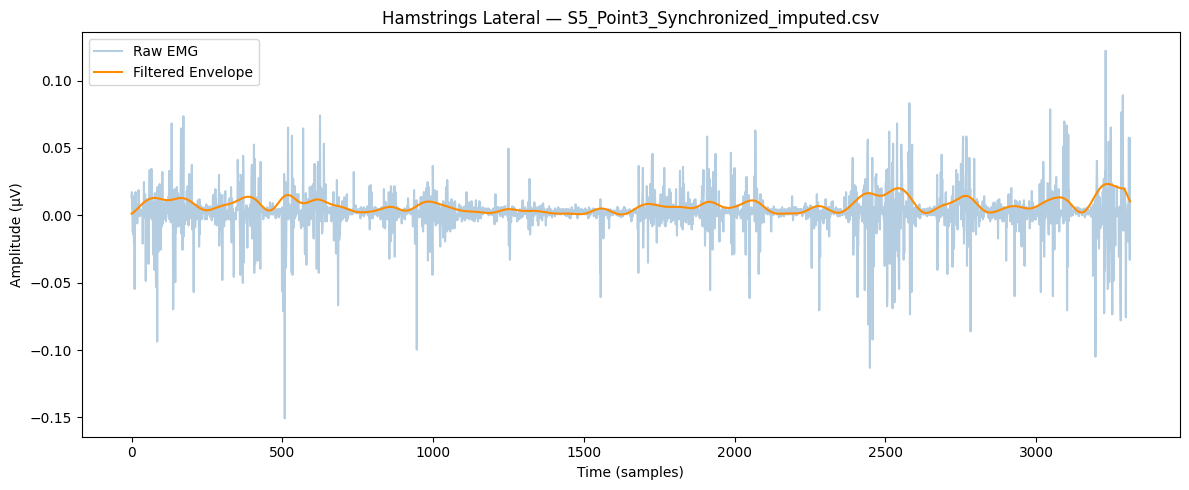

✅ Processed: S5_Point4_Synchronized_imputed.csv


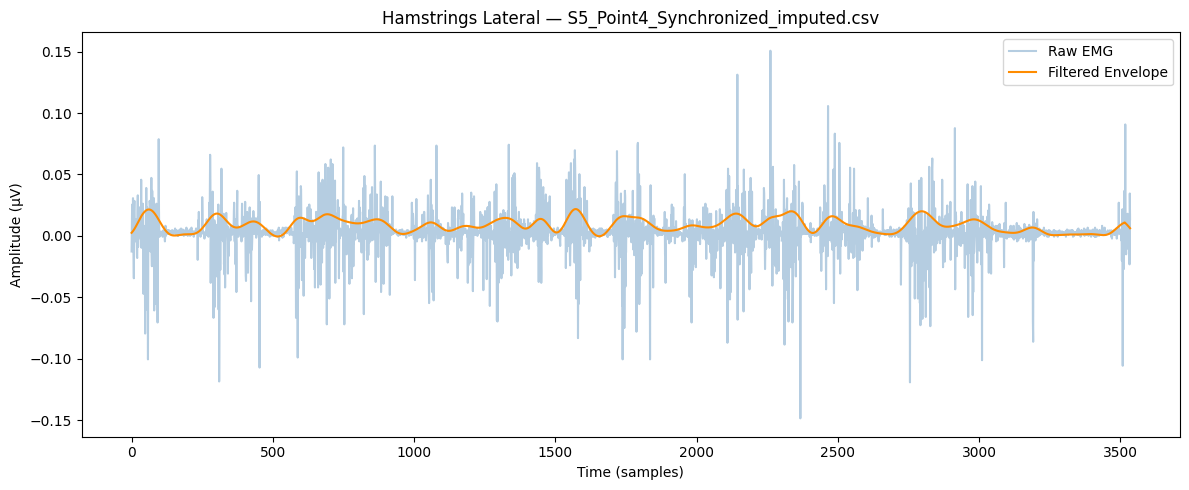

✅ Processed: S5_ReachGraspEat_Synchronized_imputed.csv


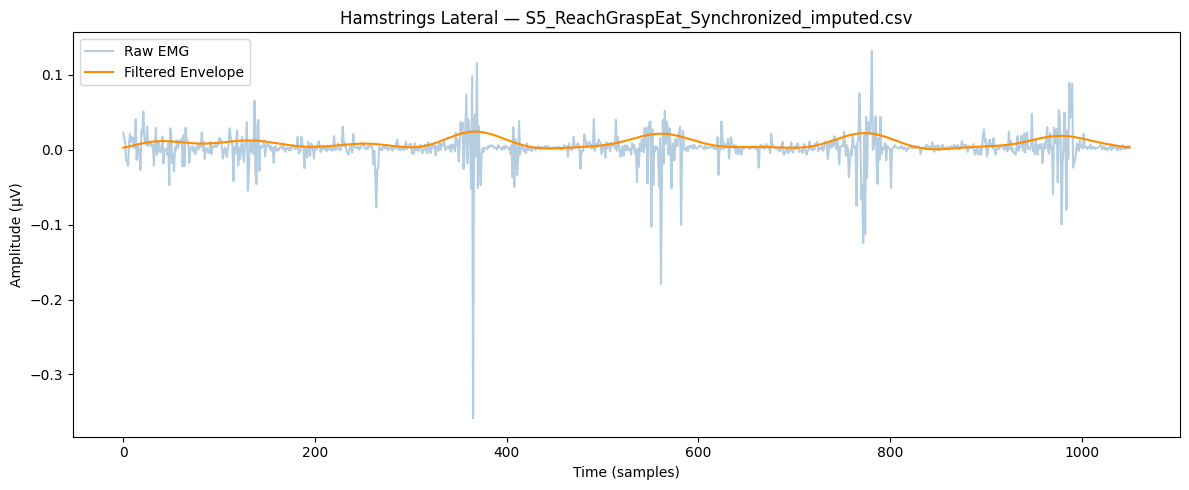

✅ Processed: S5_ShortJump_Synchronized_imputed.csv


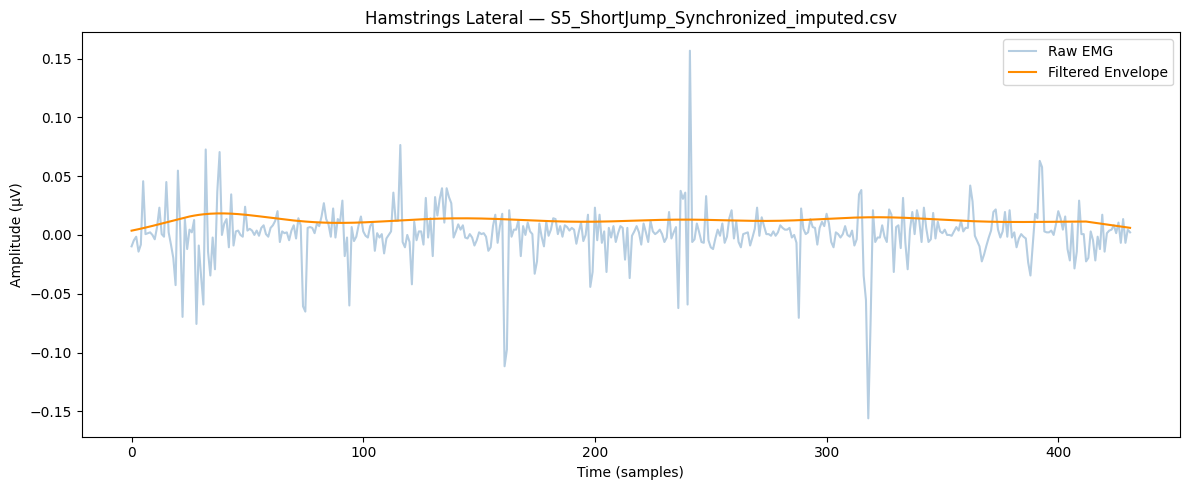

✅ Processed: S5_SideLunge_Synchronized_imputed.csv


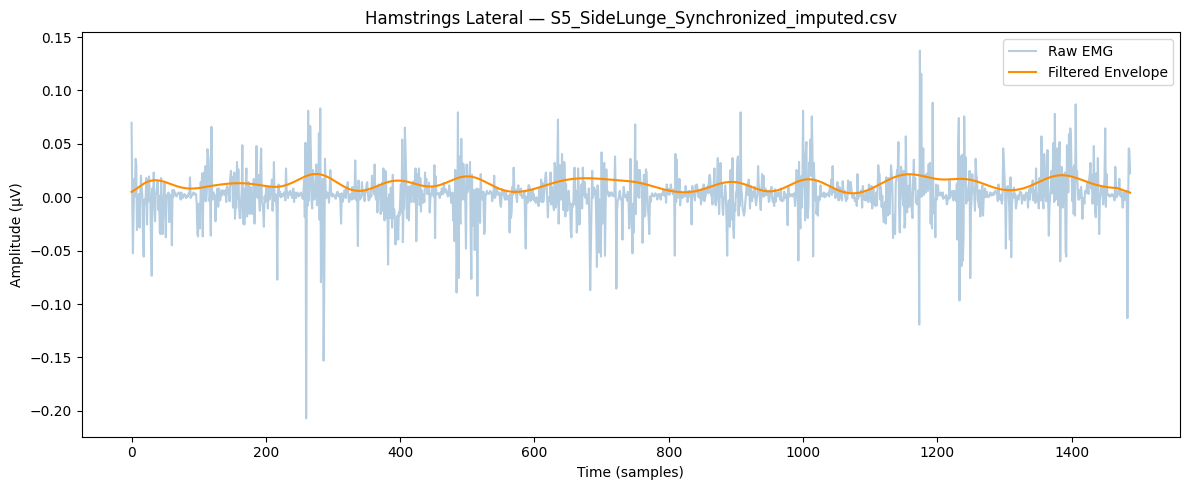

✅ Processed: S5_StepForwardLeft_Synchronized_imputed.csv


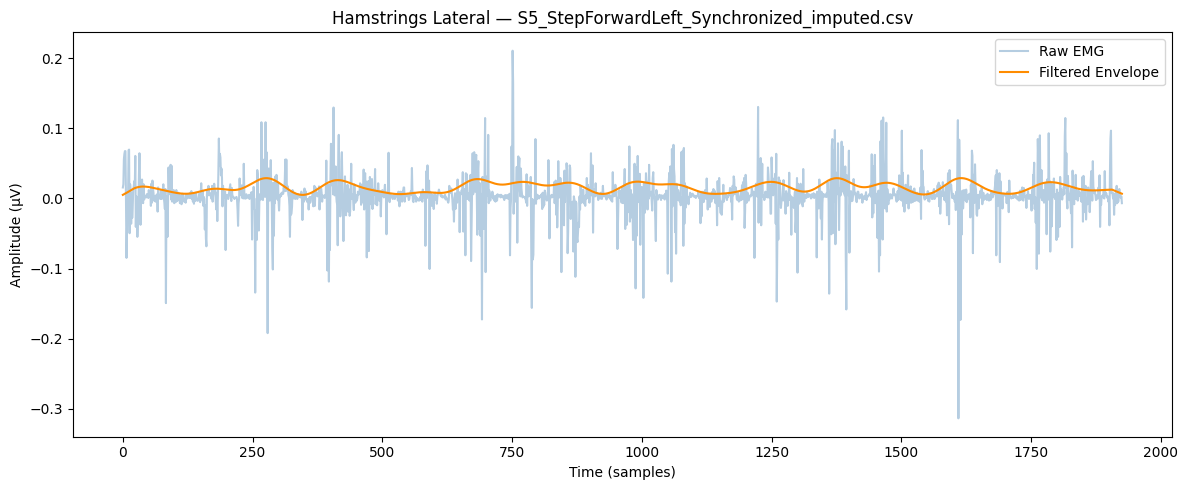

✅ Processed: S5_StepForwardRight_Synchronized_imputed.csv


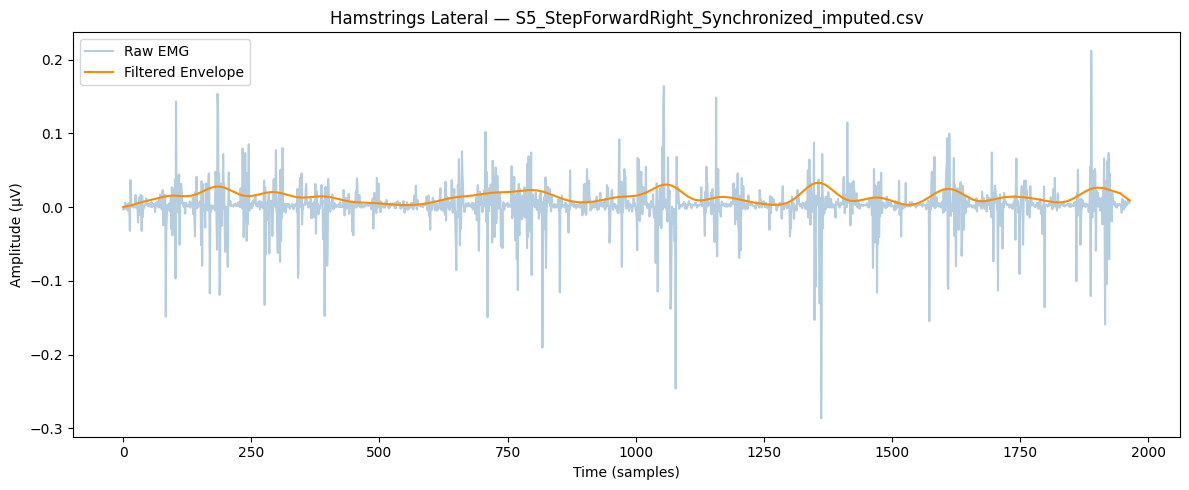

✅ Processed: S5_StepSideRight_Synchronized_imputed.csv


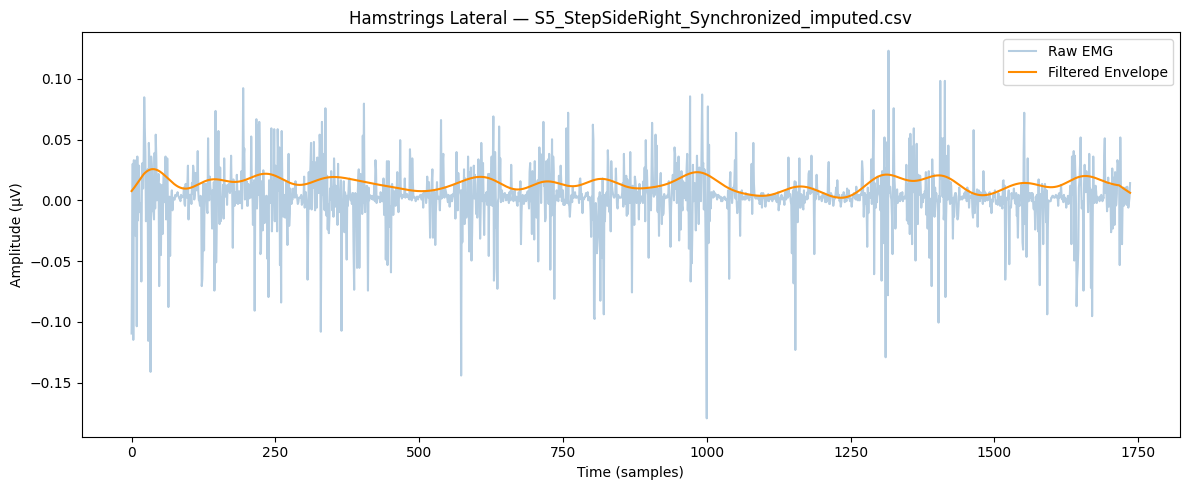

✅ Processed: S5_Tadasana_Synchronized_imputed.csv


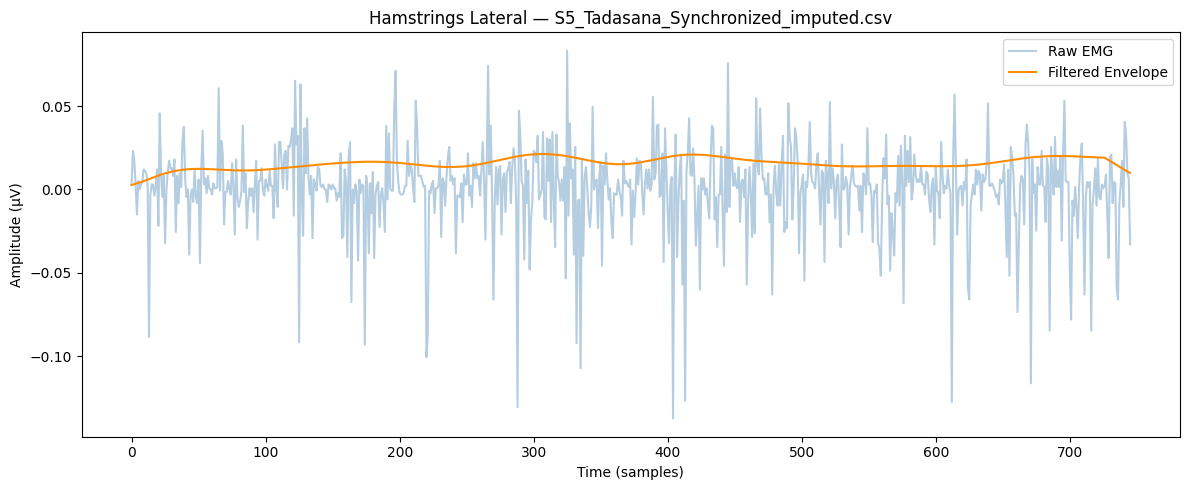

✅ Processed: S5_ThrowBall_Synchronized_imputed.csv


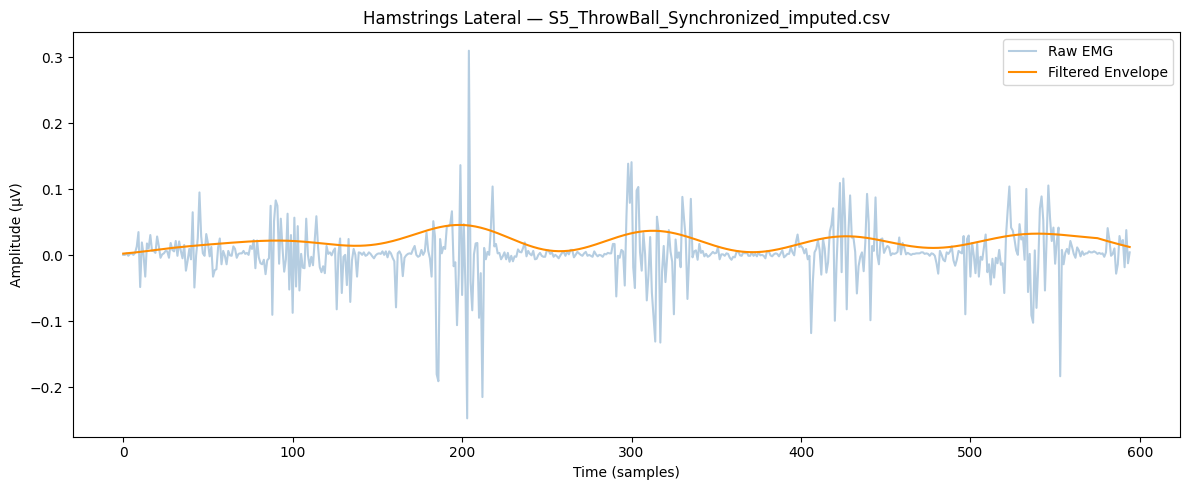

✅ Processed: S5_Trikonasana_Synchronized_imputed.csv


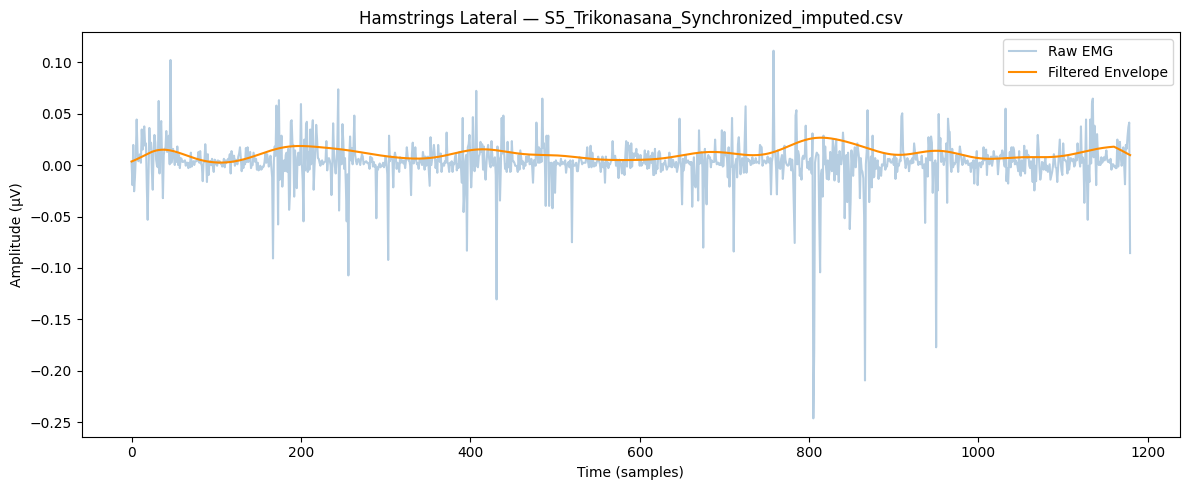

✅ Processed: S5_Utkatakonasana_Synchronized_imputed.csv


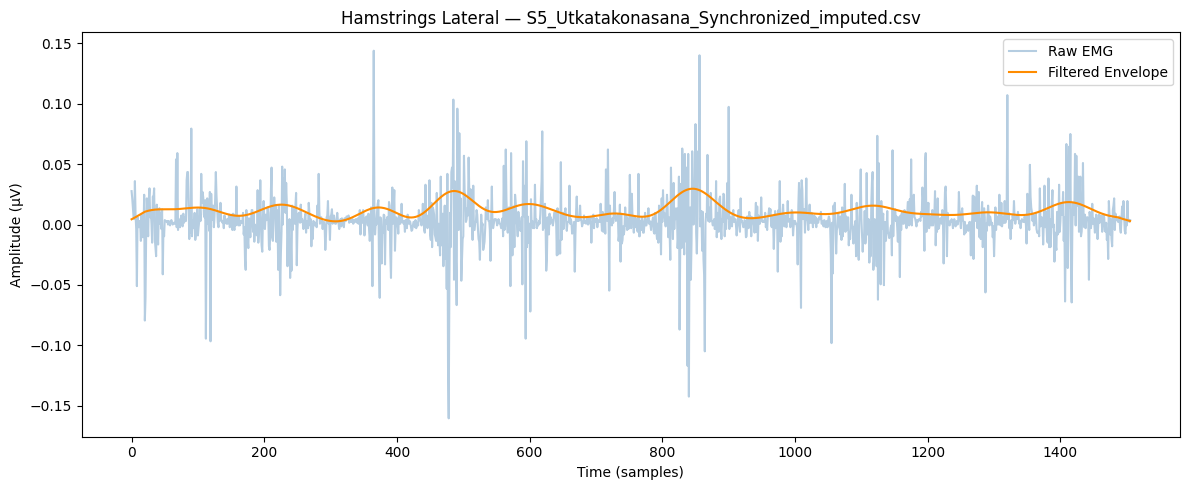

✅ Processed: S5_Virabhadrasana_Synchronized_imputed.csv


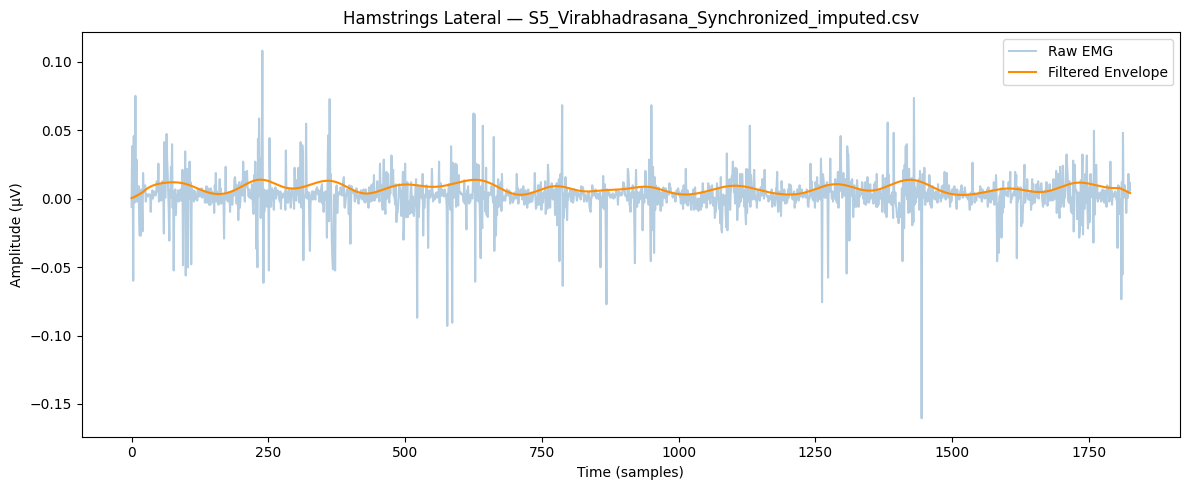

✅ Processed: S5_Vrikshasana_Synchronized_imputed.csv


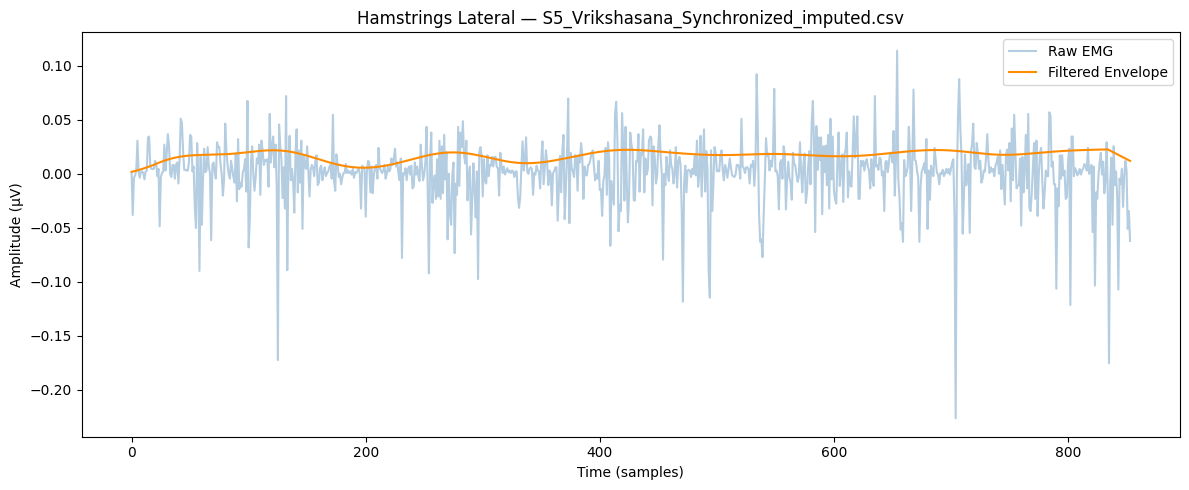

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


In [ ]:

# ------------------ CONFIG ------------------
RAW_EMG_DIR = "Subject_Data/S5/sync_data/imputed"             # Folder containing raw CSV files
OUTPUT_DIR = "Subject_Data/S5/sync_data/filtered"     # Folder to save filtered CSVs
os.makedirs(OUTPUT_DIR, exist_ok=True)

# EMG Columns
EMG_COLUMNS = [
    'Tibialis Anterior / Dorsiflexors', 'Gastrocnemius Medial', 'Gastrocnemius Lateral',
    'Hamstrings Lateral', 'Left Lumbars', 'Hamstrings Medial', 'Vastus Lateralis',
    'Vastus Medialis', 'Triceps Brachii', 'Biceps Brachii', 'Forearm M',
    'Middle/Lateral Deltoid', 'Shoulder Flexors', 'Glutei', 'Right Lumbars', 'Rectus Femoris'
]


In [ ]:

# Signal processing parameters
FS = 1000         # Sampling frequency
LOWCUT = 10       # Bandpass low cutoff
HIGHCUT = 200     # Bandpass high cutoff
WINDOW_MS = 450   # Moving average window
WINDOW_SIZE = int((WINDOW_MS / 1000) * FS)

# Plot configuration
MUSCLE_TO_PLOT = "Hamstrings Lateral"  

from scipy.signal import butter, filtfilt

from scipy.signal import butter, filtfilt

def filter_and_extract_emg_envelope(signal, fs=1000, lowpass_cut=10, ma_window_ms=40):
    from scipy.signal import butter, filtfilt

    #Bandpass 
    nyq = 0.5 * fs
    low, high = 20 / nyq, 450 / nyq
    b_band, a_band = butter(4, [low, high], btype='band')
    signal = filtfilt(b_band, a_band, signal)

    #Full-wave rectification
    rectified = np.abs(signal)

    #Low-pass filtering for linear envelope 
    low_cut = lowpass_cut / nyq
    b_low, a_low = butter(4, low_cut, btype='low')
    envelope = filtfilt(b_low, a_low, rectified)

    #smoother moving average 
    window_size = int(ma_window_ms / 1000 * fs)
    if window_size > 1:
        envelope = np.convolve(envelope, np.ones(window_size) / window_size, mode='same')

    return envelope




In [ ]:




# File Processing
def process_emg_file(input_path, output_dir):
    df = pd.read_csv(input_path)
    missing = [col for col in EMG_COLUMNS if col not in df.columns]
    if missing:
        print(f"❌ Skipping {os.path.basename(input_path)}: Missing {missing}")
        return

    # Save a copy of the raw signal for comparison
    raw_muscle_signal = df[MUSCLE_TO_PLOT].values if MUSCLE_TO_PLOT in df.columns else None

    for col in EMG_COLUMNS:
        df[col] = filter_and_extract_emg_envelope(df[col].values, FS)

    # Save to output
    output_path = os.path.join(output_dir, os.path.basename(input_path).replace(".csv", "_filtered.csv"))
    df.to_csv(output_path, index=False)
    print(f"✅ Processed: {os.path.basename(input_path)}")

    # Plotting before vs after for selected muscle
    if raw_muscle_signal is not None and MUSCLE_TO_PLOT in df.columns:
        filtered_signal = df[MUSCLE_TO_PLOT].values
        plot_comparison(raw_muscle_signal, filtered_signal, os.path.basename(input_path), MUSCLE_TO_PLOT)

# Plots
def plot_comparison(raw_signal, filtered_signal, filename, muscle):
    plt.figure(figsize=(12, 5))
    plt.plot(raw_signal, alpha=0.4, label="Raw EMG", color="steelblue")
    plt.plot(filtered_signal, label="Filtered Envelope", color="darkorange")
    plt.title(f"{muscle} — {filename}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------ RUN BATCH ------------------
def batch_filter_emg(input_dir, output_dir):
    files = sorted(glob.glob(os.path.join(input_dir, "*.csv")))
    if not files:
        print("❌ No CSV files found.")
        return
    print(f"🔍 Found {len(files)} files.")
    for file in files:
        process_emg_file(file, output_dir)

# Entry point
if __name__ == "__main__":
    batch_filter_emg(RAW_EMG_DIR, OUTPUT_DIR)


IMPUTING DATASET

In [ ]:
import pandas as pd
import numpy as np
import os
import glob

def local_average_impute(series, window_size=5):
    """
    Replaces NaNs with the average of surrounding values using a rolling window.
    
    Args:
    - series (pd.Series): The column with missing values.
    - window_size (int): Number of surrounding points to average.
    
    Returns:
    - pd.Series: The series with NaNs replaced.
    """
    # Identify NaN indices
    nan_indices = series[series.isna()].index

    for idx in nan_indices:
        # Define local window (excluding NaNs)
        lower = max(0, idx - window_size)
        upper = min(len(series), idx + window_size)
        local_values = series[lower:upper].dropna()

        # Replace NaN with mean of local window
        if not local_values.empty:
            series.at[idx] = local_values.mean()
        else:
            series.at[idx] = 0  # If all neighbors are NaN, default to 0

    return series

def process_and_save_imputed_data(file_path, output_dir):
    """
    Reads a CSV file, imputes NaNs using local average, and saves a new file.
    
    Args:
    - file_path (str): Path to the input CSV file.
    - output_dir (str): Directory to save the imputed file.
    """
    df = pd.read_csv(file_path)

    # Apply local imputation to all numeric columns
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:  # Apply only to numerical columns
            df[col] = local_average_impute(df[col])

    # Save the processed file
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, os.path.basename(file_path).replace(".csv", "_imputed.csv"))
    df.to_csv(output_path, index=False)
    print(f"✅ Saved: {output_path}")

def batch_process_emg_data(input_dir, output_dir):
    """
    Processes all CSV files in the input directory and saves imputed versions.
    
    Args:
    - input_dir (str): Directory containing raw CSV files.
    - output_dir (str): Directory to save imputed CSVs.
    """
    csv_files = glob.glob(os.path.join(input_dir, "*.csv"))
    
    if not csv_files:
        print("❌ No CSV files found in directory.")
        return

    print(f"🔍 Found {len(csv_files)} files. Processing...")
    
    for file in csv_files:
        process_and_save_imputed_data(file, output_dir)

# Run the batch processing
if __name__ == "__main__":
    INPUT_DIR = "Subject_Data/S4/sync_data"  # Set your dataset directory
    OUTPUT_DIR = "Subject_Data/S4/sync_data/imputed"  # Directory to save new files
    batch_process_emg_data(INPUT_DIR, OUTPUT_DIR)


🔍 Found 26 files. Processing...
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_ClimbOnStool_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_Dusting_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_ForwardLungeLeft_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_ForwardLungeRight_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_HandsOnWaist_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_Malasana_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_NeutralStance_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_NormalSquat_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_Parshvakonasana_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_PickObject_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_Point1_Synchronized_imputed.csv
✅ Saved: Subject_Data/S4/sync_data/imputed\S4_Poi

: 